In [1]:
import os, glob
import pandas as pd
import numpy as np
from model_utils import load_mat_file, extract_train_trials, extract_test_trials
from utils import *

In [2]:
fits_folder = "/Users/jessica.schmilovich/Documents/GSTEM Research Project/BehavioralModel-main/Fits"
all_files = [f for f in os.listdir(fits_folder) if f.endswith("_Fits_NFoldCV.mat")]
all_data = {}
for fn in all_files:
    rat = fn.split("_")[0]
    mat = load_mat_file(os.path.join(fits_folder, fn))
    all_data[rat] = mat["BestFit_Folds"]

In [3]:
fitted_rows = []

for rat, folds in all_data.items():
    for fold in folds:
        param5_lambda = fold.BestFit.params[4]  # lambda = 5th param (index 4)
        fitted_rows.append({
            "rat": rat,
            "param5": param5_lambda
        })

fitted_df = pd.DataFrame(fitted_rows)

In [5]:
# compute median lambda per rat
lam = (
    fitted_df.groupby("rat")["param5"]
    .median()
    .reset_index()
    .rename(columns={"param5": "lambda_median"})
)

# compute tertile thresholds
lambda_tertiles = np.percentile(lam["lambda_median"], [33.33, 66.67])
print(f"Lambda tertiles: {lambda_tertiles[0]:.3f}, {lambda_tertiles[1]:.3f}")


# assign group
def assign_lambda_group(val):
    if val < lambda_tertiles[0]:
        return "poor"
    elif val < lambda_tertiles[1]:
        return "medium"
    else:
        return "good"


lam["lambda_group"] = lam["lambda_median"].apply(assign_lambda_group)

Lambda tertiles: 0.390, 0.803


In [6]:
all_trials = []

for rat in lam["rat"]:
    file = os.path.join(fits_folder, f"{rat}_Fits_NFoldCV.mat")
    mat_data = load_mat_file(file)
    folds = mat_data.get("BestFit_Folds", [])

    # extract fold 0
    train_df = extract_train_trials(folds, rat=rat)
    test_df = extract_test_trials(folds, rat=rat)

    # get trial counts from fold 0
    train_ntrials, test_ntrials = [], []
    if len(folds) > 0:
        fold_0 = folds[0]
        if hasattr(fold_0, "ratTrial_TrainFold"):
            train_ntrials = getattr(fold_0.ratTrial_TrainFold, "ntrials", [])
            train_ntrials = train_ntrials.flatten() if hasattr(train_ntrials, "flatten") else train_ntrials
        if hasattr(fold_0, "ratTrial_TestFold"):
            test_ntrials = getattr(fold_0.ratTrial_TestFold, "ntrials", [])
            test_ntrials = test_ntrials.flatten() if hasattr(test_ntrials, "flatten") else test_ntrials

    # use only fold 0
    train_fold_0 = train_df[train_df["Fold"] == 0].copy()
    test_fold_0 = test_df[test_df["Fold"] == 0].copy()
    df = pd.concat([train_fold_0, test_fold_0], ignore_index=True)

    # add session number
    all_ntrials = list(train_ntrials) + list(test_ntrials)
    df = add_session_numbers(df, all_ntrials) if len(all_ntrials) else df.assign(session=1)
    df = df.rename(columns={"session": "session_num"})

    # add transitions, z-scores, transition types
    df = get_transition_dynamics_from_df(df)
    df = df[df["wait_time"] <= 30].copy()
    df["z_wait_time"] = df.groupby("reward")["wait_time"].transform(lambda x: (x - x.mean()) / x.std())
    df["transition_type"] = identify_transition_types(df)

    # attach rat + lambda group
    df["rat"] = rat
    df["lambda_group"] = lam.loc[lam["rat"] == rat, "lambda_group"].values[0]
    all_trials.append(df)

# combine all rats
trials_df = pd.concat(all_trials, ignore_index=True)
reward_map = {4: 5, 8: 10, 16: 20, 32: 40, 64: 80}
trials_df["reward"] = trials_df["reward"].replace(reward_map)

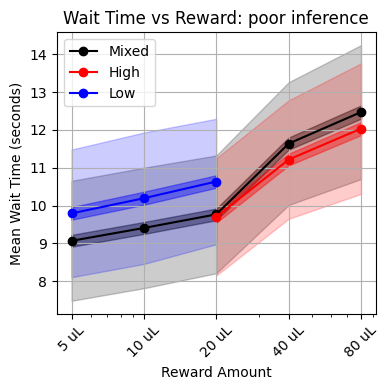

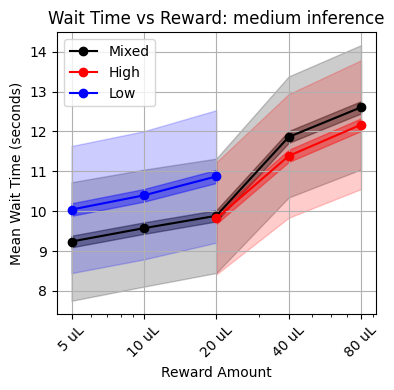

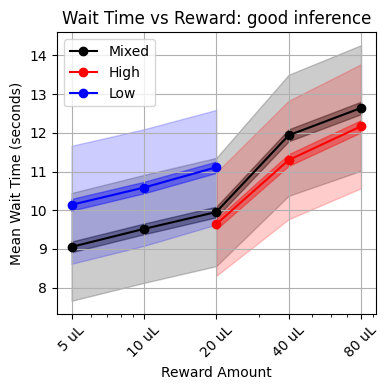

In [7]:
for group in ["poor", "medium", "good"]:
    subset = trials_df[trials_df["lambda_group"] == group]
    plot_wait_times_aggregated(subset)
    plt.title(f"Wait Time vs Reward: {group} inference")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

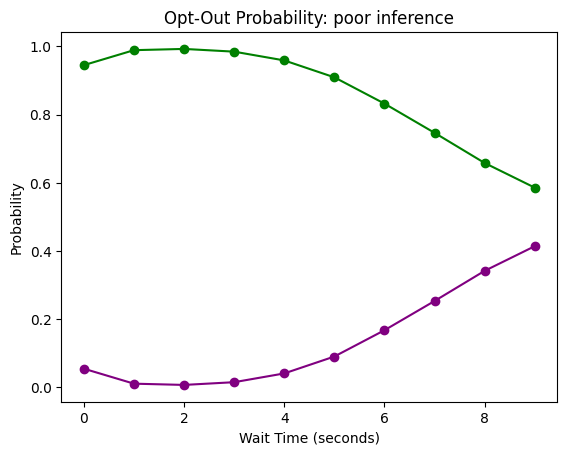

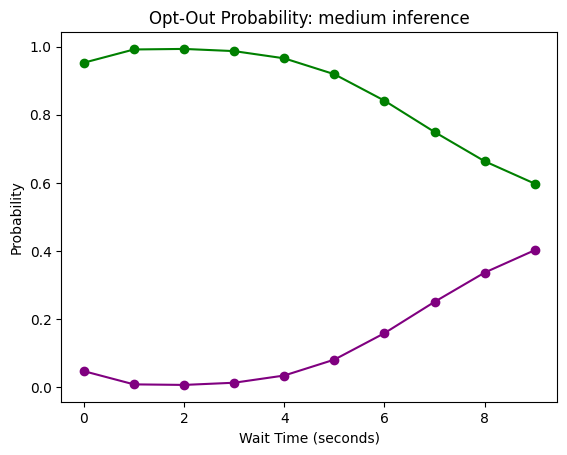

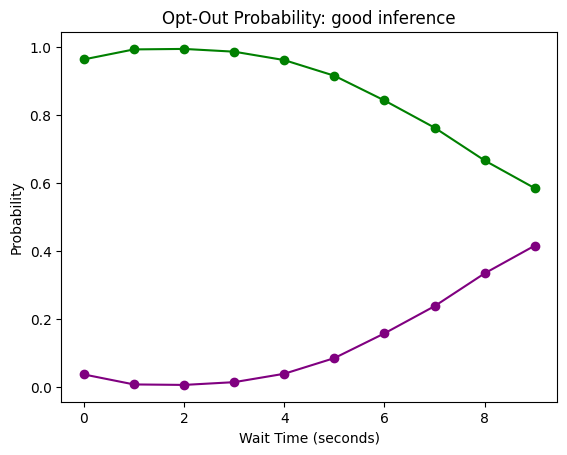

In [9]:
wait_bins = np.arange(0, 10.5, 1)

for group in ["poor", "medium", "good"]:
    subset = trials_df[trials_df["lambda_group"] == group]
    fig, ax = plt.subplots()
    get_optout_probability(subset, wait_bins, ax=ax)
    ax.set_title(f"Opt-Out Probability: {group} inference")
    plt.show()

/var/folders/54/6j5bswxd737_q17mf8979d8mgk3r9g/T/ipykernel_67153/4013704355.py:26: RuntimeWarning: Mean of empty slice
  avg_transitions = {col: np.nanmean(trans_mats[col], axis=0) for col in transition_cols}


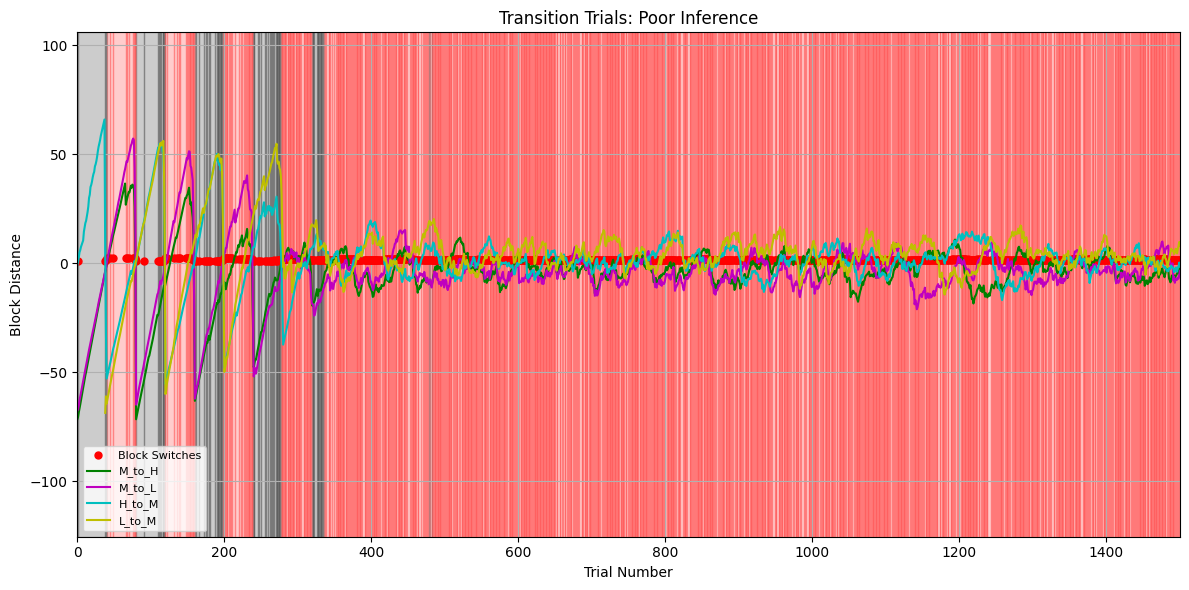

/var/folders/54/6j5bswxd737_q17mf8979d8mgk3r9g/T/ipykernel_67153/4013704355.py:26: RuntimeWarning: Mean of empty slice
  avg_transitions = {col: np.nanmean(trans_mats[col], axis=0) for col in transition_cols}


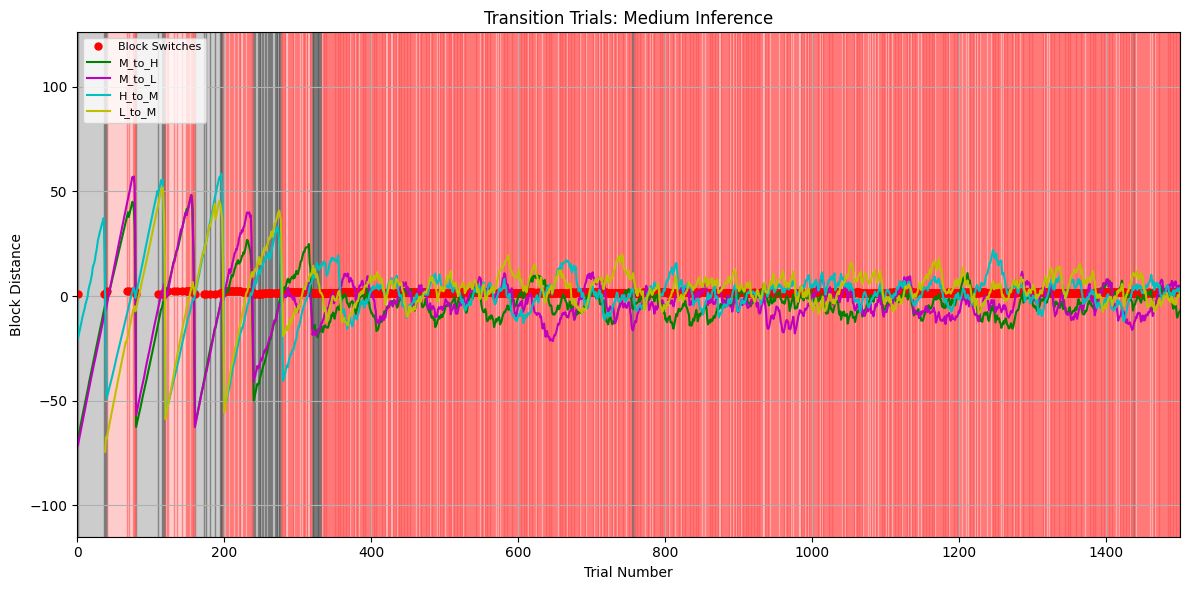

/var/folders/54/6j5bswxd737_q17mf8979d8mgk3r9g/T/ipykernel_67153/4013704355.py:26: RuntimeWarning: Mean of empty slice
  avg_transitions = {col: np.nanmean(trans_mats[col], axis=0) for col in transition_cols}


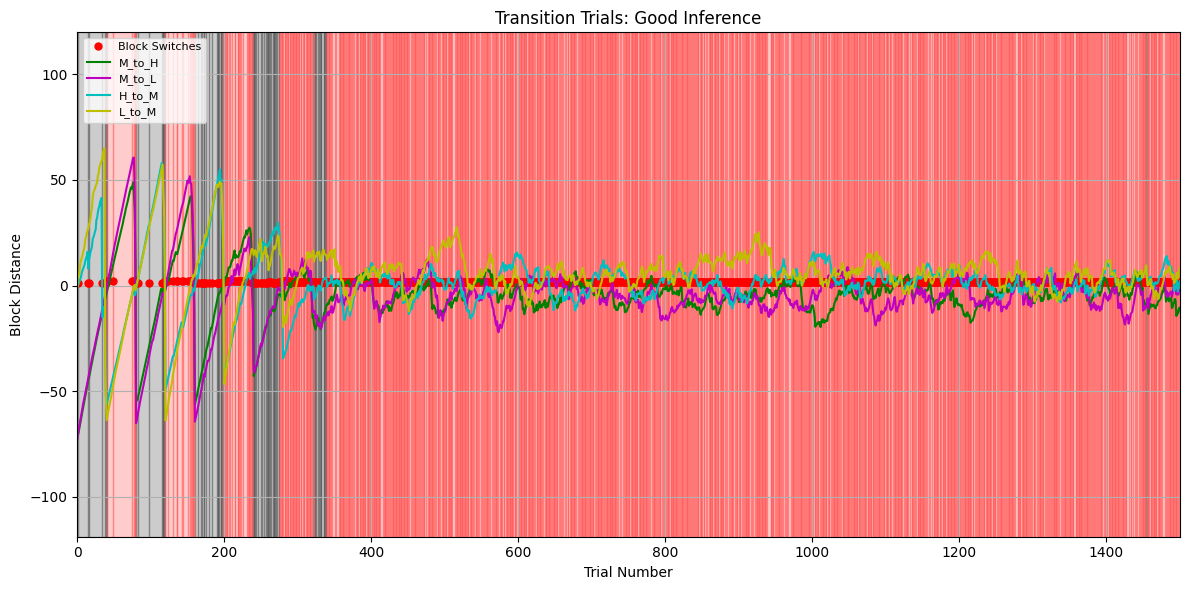

In [12]:
block_colors = {1: 'black', 2: 'red', 3: 'blue'}
transition_cols = ['M_to_H', 'M_to_L', 'H_to_M', 'L_to_M']
transition_colors = {'M_to_H': 'g', 'M_to_L': 'm', 'H_to_M': 'c', 'L_to_M': 'y'}

for group in ["poor", "medium", "good"]:
    group_data = trials_df[trials_df["lambda_group"] == group].copy()

    group_data = group_data.reset_index(drop=True)

    max_len = group_data.groupby("rat").size().max()
    rats = group_data["rat"].unique()

    block_mat = np.full((len(rats), max_len), np.nan)
    trans_mats = {col: np.full((len(rats), max_len), np.nan) for col in transition_cols}

    for i, rat in enumerate(rats):
        rat_data = group_data[group_data["rat"] == rat].reset_index(drop=True)
        n = len(rat_data)
        block_mat[i, :n] = rat_data["block"]
        for col in transition_cols:
            if col in rat_data.columns:
                trans_mats[col][i, :n] = rat_data[col]

    # compute averages across rats from each lambda group
    avg_block = np.nanmean(block_mat, axis=0)
    avg_transitions = {col: np.nanmean(trans_mats[col], axis=0) for col in transition_cols}

    # detect block switches from average block trace
    b0 = avg_block[:-1]
    b1 = avg_block[1:]
    switches = np.where(b0 != b1)[0] + 1
    valid_switches = switches[switches < len(avg_block)]

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(valid_switches, avg_block[valid_switches], 'ro', markersize=5, label='Block Switches')

    for i, t0 in enumerate(valid_switches):
        if i == 0:
            block_val = int(round(avg_block[0]))
            color = block_colors.get(block_val, 'gray')
            plt.axvspan(0, t0, color=color, alpha=0.2)
        else:
            block_val = int(round(avg_block[t0 - 1]))
            color = block_colors.get(block_val, 'gray')
            plt.axvspan(valid_switches[i - 1], t0, color=color, alpha=0.2)

    # overlay averaged transition distances
    for col in transition_cols:
        plt.plot(avg_transitions[col], transition_colors[col], label=col)

    plt.xlim(0, min(1500, len(avg_block)))
    plt.title(f"Transition Trials: {group.title()} Inference")
    plt.xlabel("Trial Number")
    plt.ylabel("Block Distance")
    plt.legend(fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

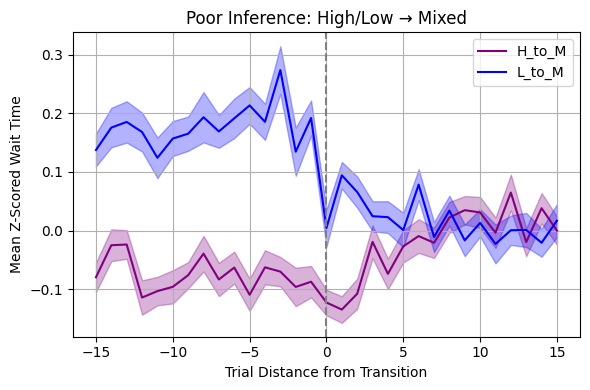

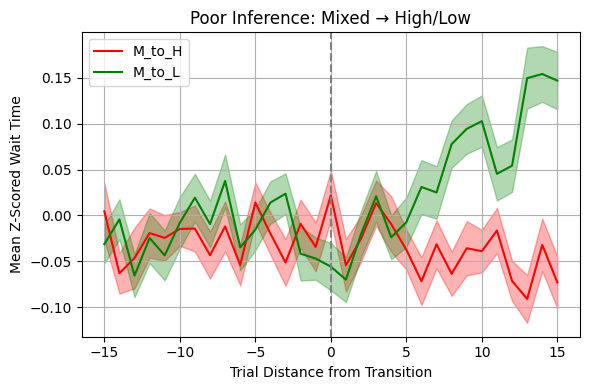

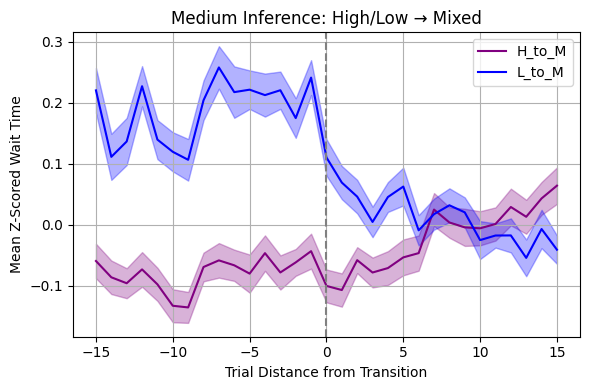

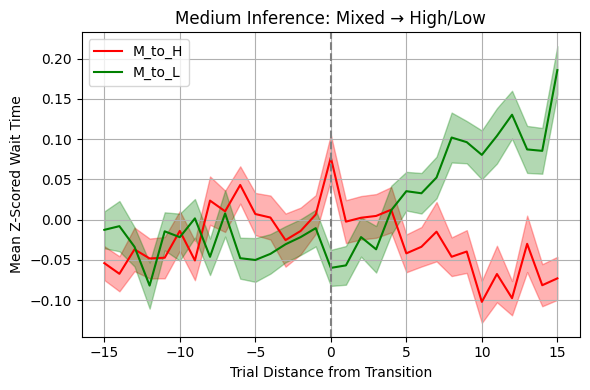

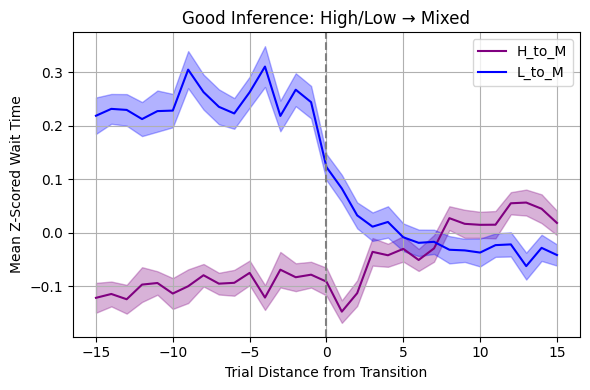

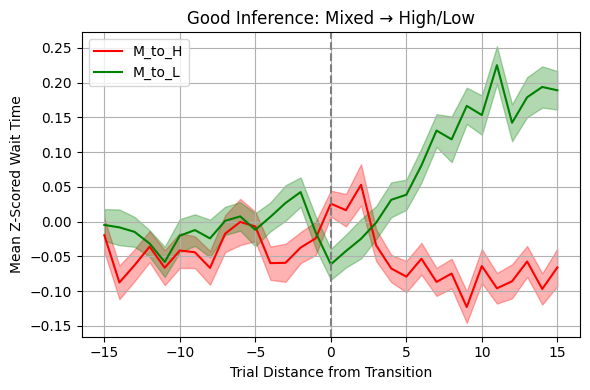

In [13]:
max_trials = 15
ntrials = 2 * max_trials + 1
x_vals = np.arange(-max_trials, max_trials + 1)
tname = ['M_to_H', 'M_to_L', 'H_to_M', 'L_to_M']

for group in ["poor", "medium", "good"]:
    group_df = trials_df[trials_df["lambda_group"] == group].copy()
    group_dynamics = []

    for rat in group_df["rat"].unique():
        rat_df = group_df[group_df["rat"] == rat].reset_index(drop=True).copy()

        rat_df = get_transition_dynamics_from_df(rat_df)

        z_wait_times = np.empty((ntrials, len(tname)))
        z_wait_times.fill(np.nan)

        for i, t in enumerate(tname):
            trials_to_use = rat_df[
                (~rat_df['z_wait_time'].isna()) &
                (~rat_df[t].isna()) &
                (rat_df[t] >= -max_trials) &
                (rat_df[t] <= max_trials)
                ].index

            distances = rat_df.loc[trials_to_use, t].values.astype(int)
            z_scores = rat_df.loc[trials_to_use, 'z_wait_time'].values

            for d in range(-max_trials, max_trials + 1):
                mask = distances == d
                if np.any(mask):
                    z_wait_times[d + max_trials, i] = z_scores[mask].mean()

        group_dynamics.append(z_wait_times)

    if len(group_dynamics) == 0:
        print(f"No dynamics for group: {group}")
        continue

    group_stack = np.stack(group_dynamics)
    avg_z_dynamics = np.nanmean(group_stack, axis=0)
    n_rats = group_stack.shape[0]
    sem_z_dynamics = np.nanstd(group_stack, axis=0) / np.sqrt(n_rats - 1)

    # plot High/Low → Mixed
    plt.figure(figsize=(6, 4))
    plt.plot(x_vals, avg_z_dynamics[:, 2], label='H_to_M', color='purple')
    plt.fill_between(x_vals, avg_z_dynamics[:, 2] - sem_z_dynamics[:, 2], avg_z_dynamics[:, 2] + sem_z_dynamics[:, 2], alpha=0.3, color='purple')
    plt.plot(x_vals, avg_z_dynamics[:, 3], label='L_to_M', color='blue')
    plt.fill_between(x_vals, avg_z_dynamics[:, 3] - sem_z_dynamics[:, 3], avg_z_dynamics[:, 3] + sem_z_dynamics[:, 3], alpha=0.3, color='blue') 
    plt.axvline(0, color='gray', linestyle='--')
    plt.xlabel('Trial Distance from Transition')
    plt.ylabel('Mean Z-Scored Wait Time')
    plt.title(f'{group.title()} Inference: High/Low → Mixed')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # plot Mixed → High/Low
    plt.figure(figsize=(6, 4))
    plt.plot(x_vals, avg_z_dynamics[:, 0], label='M_to_H', color='red')
    plt.fill_between(x_vals, avg_z_dynamics[:, 0] - sem_z_dynamics[:, 0], avg_z_dynamics[:, 0] + sem_z_dynamics[:, 0], alpha=0.3, color='red')
    plt.plot(x_vals, avg_z_dynamics[:, 1], label='M_to_L', color='green')
    plt.fill_between(x_vals, avg_z_dynamics[:, 1] - sem_z_dynamics[:, 1], avg_z_dynamics[:, 1] + sem_z_dynamics[:, 1], alpha=0.3, color='green')
    plt.axvline(0, color='gray', linestyle='--')
    plt.xlabel('Trial Distance from Transition')
    plt.ylabel('Mean Z-Scored Wait Time')
    plt.title(f'{group.title()} Inference: Mixed → High/Low')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

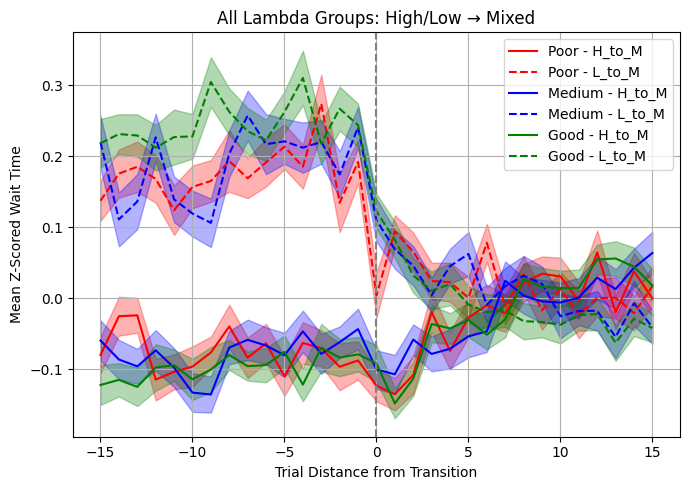

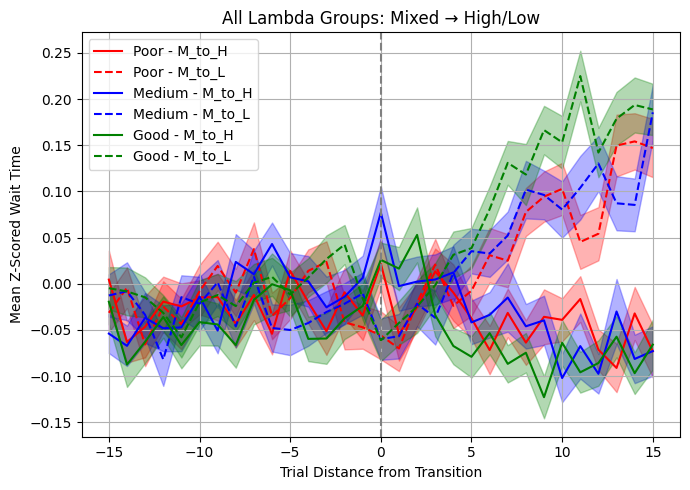

In [21]:
# plot all lambda groups in the same transition plots (combined visualization)
from collections import defaultdict

max_trials = 15
ntrials = 2 * max_trials + 1
x_vals = np.arange(-max_trials, max_trials + 1)
tname = ['M_to_H', 'M_to_L', 'H_to_M', 'L_to_M']

# store results per group and transition
group_results = defaultdict(dict)

# one color per group
group_colors = {
    "poor": "red",    # Red
    "medium": "blue",  # Blue
    "good": "green"     # Green
}

# distinguish transitions by line style
linestyles = {
    "H_to_M": "solid",
    "L_to_M": "dashed",
    "M_to_H": "solid",
    "M_to_L": "dashed"
}

for group in ["poor", "medium", "good"]:
    group_df = trials_df[trials_df["lambda_group"] == group].copy()
    group_dynamics = []

    for rat in group_df["rat"].unique():
        rat_df = group_df[group_df["rat"] == rat].reset_index(drop=True).copy()
        rat_df = get_transition_dynamics_from_df(rat_df)

        z_wait_times = np.full((ntrials, len(tname)), np.nan)

        for i, t in enumerate(tname):
            trials_to_use = rat_df[
                (~rat_df['z_wait_time'].isna()) &
                (~rat_df[t].isna()) &
                (rat_df[t] >= -max_trials) &
                (rat_df[t] <= max_trials)
            ].index

            distances = rat_df.loc[trials_to_use, t].values.astype(int)
            z_scores = rat_df.loc[trials_to_use, 'z_wait_time'].values

            for d in range(-max_trials, max_trials + 1):
                mask = distances == d
                if np.any(mask):
                    z_wait_times[d + max_trials, i] = z_scores[mask].mean()

        group_dynamics.append(z_wait_times)

    group_stack = np.stack(group_dynamics)
    avg_z = np.nanmean(group_stack, axis=0)
    sem_z = np.nanstd(group_stack, axis=0, ddof=1) / np.sqrt(group_stack.shape[0] - 1)

    for i, t in enumerate(tname):
        group_results[group][t] = (avg_z[:, i], sem_z[:, i])

# plot 1: High/Low → Mixed (H_to_M and L_to_M)
plt.figure(figsize=(7, 5))
for group in ["poor", "medium", "good"]:
    for t in ["H_to_M", "L_to_M"]:
        mean, sem = group_results[group][t]
        label = f"{group.title()} - {t}"
        plt.plot(x_vals, mean, label=label, color=group_colors[group], linestyle=linestyles[t])
        plt.fill_between(x_vals, mean - sem, mean + sem, alpha=0.3, color=group_colors[group])
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Trial Distance from Transition")
plt.ylabel("Mean Z-Scored Wait Time")
plt.title("All Lambda Groups: High/Low → Mixed")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# plot 2: Mixed → High/Low (M_to_H and M_to_L)
plt.figure(figsize=(7, 5))
for group in ["poor", "medium", "good"]:
    for t in ["M_to_H", "M_to_L"]:
        mean, sem = group_results[group][t]
        label = f"{group.title()} - {t}"
        plt.plot(x_vals, mean, label=label, color=group_colors[group], linestyle=linestyles[t])
        plt.fill_between(x_vals, mean - sem, mean + sem, alpha=0.3, color=group_colors[group])
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Trial Distance from Transition")
plt.ylabel("Mean Z-Scored Wait Time")
plt.title("All Lambda Groups: Mixed → High/Low")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# number of rats in each lambda group
rat_counts = trials_df[['rat', 'lambda_group']].drop_duplicates()
group_counts = rat_counts['lambda_group'].value_counts()
print(group_counts)

lambda_group
medium    104
good      103
poor      103
Name: count, dtype: int64
